In [1]:
import numpy as np
from scipy.linalg import expm
from scipy.linalg import eig
import functions as fn
import helpers as hlp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ace_tools_open as tools

In [2]:
N = 4
# check that the irreducible tensor basis is normalized
F_list = hlp.build_fourier_basis(N)
B = np.column_stack([hlp.vec(F) for F in F_list])
# Compute Gram matrix G = B^† B
G = B.conj().T @ B

# Check off-diagonal and diagonal entries
max_off = np.max(np.abs(G - np.diag(np.diag(G))))
min_on = np.min(np.abs(np.diag(G)))

print(f"Max off-diagonal magnitude: {max_off:.2e} (should be ~0)")
print(f"Min diagonal magnitude:    {min_on:.2e} (should be ~1)")

Max off-diagonal magnitude: 1.17e-16 (should be ~0)
Min diagonal magnitude:    1.00e+00 (should be ~1)


In [3]:
ε, J = 0.25, 1.0
L_q = hlp.quantum_liouvillian(N, ε, J)

B_inv = np.linalg.inv(B)
L_q_in_Z4_tensor_basis = B_inv @ L_q @ B

In [4]:
results = []
max_resid = 0.0

evecs_dic, evals_dic = {}, {}
for mu in range(N):
    block = L_q_in_Z4_tensor_basis[mu*N:(mu+1)*N, mu*N:(mu+1)*N]
    vals, vecs = eig(block)
    for k in range(N):
        λ = vals[k]
        v = vecs[:, k]

        c = np.zeros(N**2, complex)
        c[mu*4:(mu+1)*4] = v
        ψ = B @ c
        resid = L_q @ ψ - λ * ψ
        evecs_dic[(mu, k)] = ψ
        evals_dic[(mu, k)] = λ
        
        results.append({
            'μ': mu,
            'k': k,
            'λ': np.round(vals[k], 8),
            'coeffs in the T_n^mu basis': [np.round(c, 4) for c in v],
            'residual_norm': np.linalg.norm(resid)
        })
        assert np.isclose(np.linalg.norm(resid), 0, atol=1e-8), f"Residual norm is not close to zero: {np.linalg.norm(resid)}"
        
        max_resid = max(max_resid, np.linalg.norm(resid))
        
        
# Create global ordering 0..15 by descending real part
all_items = list(evals_dic.items())  # [((mu,k), lambda), ...]
# Sort by: 1) real part of λ descending, 2) μ ascending, 3) k ascending
sorted_all = sorted(
    all_items,
    key=lambda item: (
        -np.round(item[1].real,3),    # negative → descending
        item[0][0],       # μ ascending
        -np.round(item[1].imag,3)        # k ascending
    )
)
ordering_global = {item[0]: rank+1 for rank, item in enumerate(sorted_all)}
# Add global ordering to results
for res in results:
    mu, k = res['μ'], res['k']
    res['global_ordering'] = ordering_global[(mu, k)]
    res['λ'] = np.round(res['λ'], 8)  # Round eigenvalue for consistency
    
# Sort results by global ordering
results.sort(key=lambda x: x['global_ordering'])
# 4) Present in DataFrame
df_results = pd.DataFrame(results)
tools.display_dataframe_to_user("", df_results)

Loading ITables v2.4.2 from the internet... (need help?)


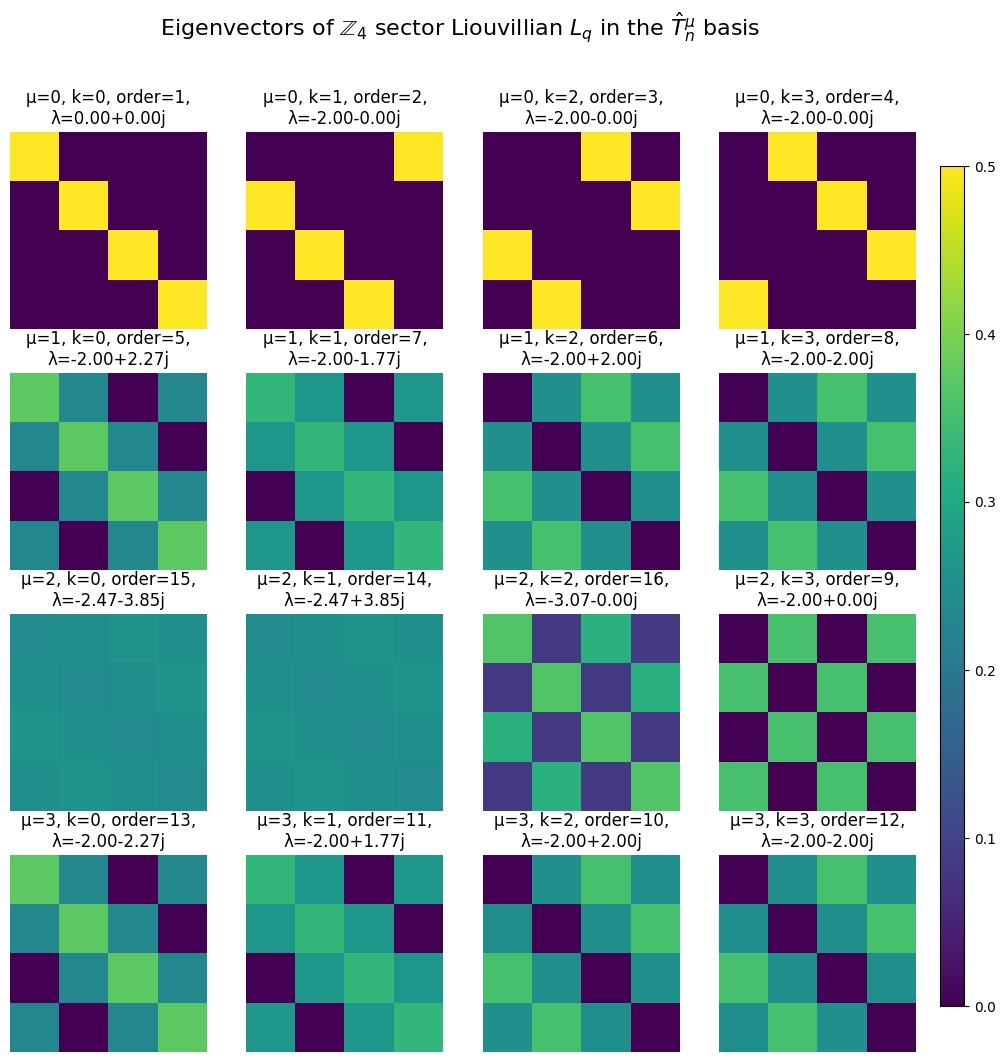

In [5]:
fig, axs = plt.subplots(N, N, figsize=(12, 12))
fig.suptitle(rf"Eigenvectors of $\mathbb{{Z}}_{N}$ sector Liouvillian $L_q$ in the $\hat T_n^\mu$ basis", fontsize=16)
abs_max = np.max([np.abs(v).max() for v in evecs_dic.values()])
abs_min = np.min([np.abs(v).min() for v in evecs_dic.values()])

for mu in range(N):
    for k in range(N):
        ψ = evecs_dic[(mu, k)]
        λ = evals_dic[(mu, k)]

        ax = axs[mu, k]
        im = ax.imshow(
            np.abs(ψ.reshape(N, N, order='F')),
            cmap='viridis',
            vmin=abs_min,
            vmax=abs_max
        )
        ax.set_title(f"μ={mu}, k={k}, order={ordering_global[(mu, k)]},\nλ={λ:.2f}")
        ax.axis('off')

fig.subplots_adjust(right=0.88)
cbar_ax = fig.add_axes([0.90, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax, orientation='vertical')
plt.show()


In [69]:
a, b, c = 1/10, -1/5, -1/2
rho1 = evecs_dic[(0,0)]/2 + a*(evecs_dic[(0,1)] + evecs_dic[(0,3)]) + b*evecs_dic[(0,2)] + c*evecs_dic[(2,2)]
a, b, c, d = -1/9, 1/9, -1/5, 1/8
rho2 = evecs_dic[(0,0)]/2 + a*(evecs_dic[(0,1)] + evecs_dic[(0,3)]) + b*evecs_dic[(0,2)] + c*(evecs_dic[(1,0)]+evecs_dic[(3,0)]) + d*(evecs_dic[(2,1)]+evecs_dic[(2,0)])
rho1 = rho1.reshape(4, 4, order='F')
rho2 = rho2.reshape(4, 4, order='F')

fn.print_matrix(rho2)
# Hermitize and renormalize
assert np.allclose(rho1, rho1.conj().T), "rho1 must be Hermitian"
assert np.allclose(rho2, rho2.conj().T), "rho2 must be Hermitian"
assert np.isclose(np.trace(rho1), 1), "rho1 must be normalized (trace = 1), but trace = {}".format(np.trace(rho1))
assert np.isclose(np.trace(rho2), 1), "rho2 must be normalized (trace = 1), but trace = {}".format(np.trace(rho2))
assert np.all(np.linalg.eigvals(rho1) >= 0), "rho1 must be positive semidefinite, but eigenvalues are {}".format(np.linalg.eigvals(rho1))
assert np.all(np.linalg.eigvals(rho2) >= 0), "rho2 must be positive semidefinite, but eigenvalues are {}".format(np.linalg.eigvals(rho2))

print("\n\nAsymmetry S(rho1) =", hlp.asymmetry(rho1), "*"*90)
print("\nrho1 =")
fn.print_matrix(rho1)
print("\n\nAsymmetry S(rho2) =", hlp.asymmetry(rho2), "*"*90)
print("\nrho2 =")
fn.print_matrix(rho2)


(0.1531-0j)      	(-0.0556-0.0586j)	(0.1201+0j)      	(-0.0556+0.0737j)
(-0.0556+0.0586j)	(0.197+0j)       	(-0.0556+0.0586j)	(-0.009-0j)      
(0.1201+0j)      	(-0.0556-0.0586j)	(0.4529+0j)      	(-0.0556+0.0737j)
(-0.0556-0.0737j)	(-0.009-0j)      	(-0.0556-0.0737j)	(0.197-0j)       


Asymmetry S(rho1) = 0.5139697353409276 ******************************************************************************************

rho1 =
(0.0675-0j)   	(0.05+0.0426j)	(0.0598+0j)   	(0.05+0.0426j)
(0.05-0.0426j)	(0.4325+0j)   	(0.05-0.0426j)	(-0.2598-0j)  
(0.0598-0j)   	(0.05+0.0426j)	(0.0675-0j)   	(0.05+0.0426j)
(0.05-0.0426j)	(-0.2598+0j)  	(0.05-0.0426j)	(0.4325+0j)   


Asymmetry S(rho2) = 0.21265389089438336 ******************************************************************************************

rho2 =
(0.1531-0j)      	(-0.0556-0.0586j)	(0.1201+0j)      	(-0.0556+0.0737j)
(-0.0556+0.0586j)	(0.197+0j)       	(-0.0556+0.0586j)	(-0.009-0j)      
(0.1201+0j)      	(-0.0556-0.0586j)	(0.4529+0j)

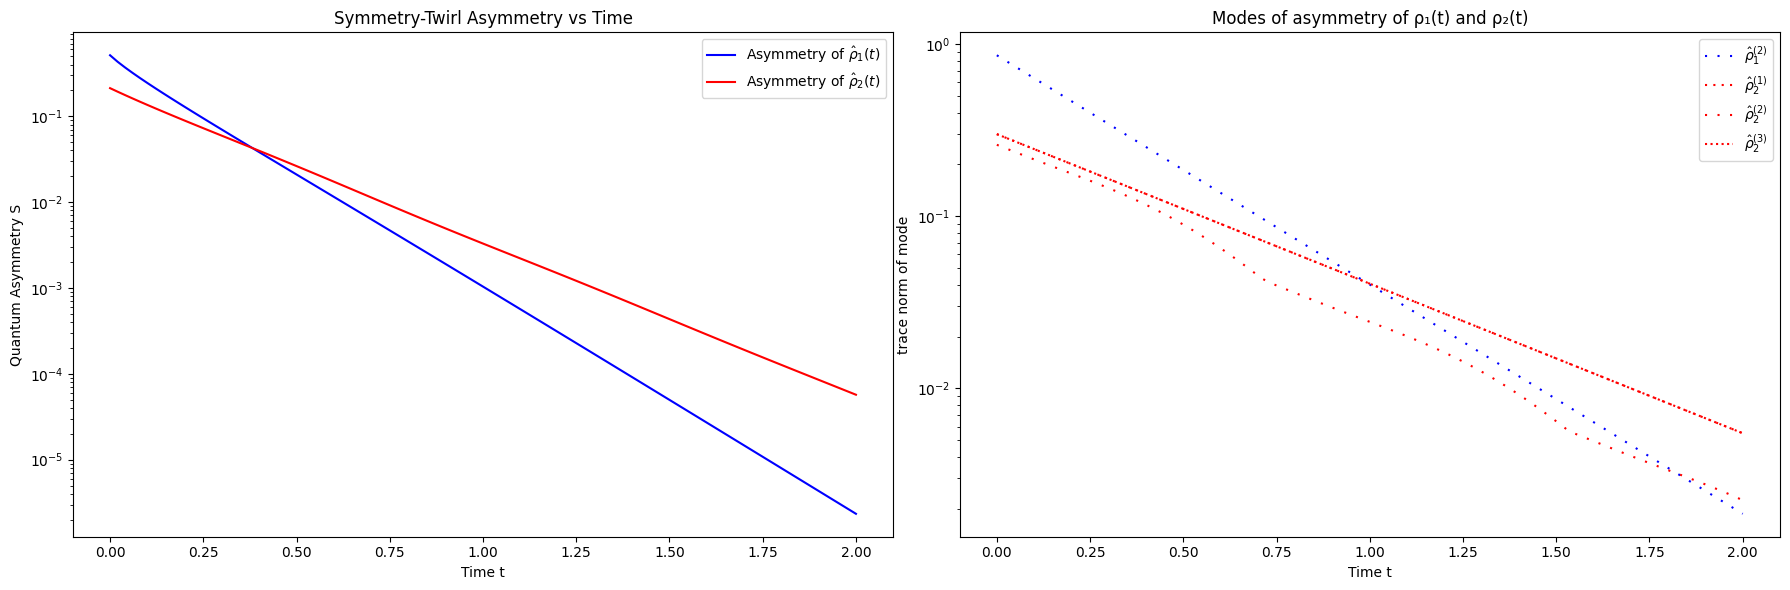

In [86]:
%matplotlib inline
fig, axs = plt.subplots(1, 2, figsize=(18, 6))

# Time evolution
t = np.linspace(0, 2, 100)
S1, S2 = np.zeros(len(t)), np.zeros(len(t))
modes1, modes2 = np.zeros((len(t), 4)), np.zeros((len(t), 4))
for t_idx, ti in enumerate(t):
    evo = expm(L_q * ti)
    r1_t = evo.dot(rho1.flatten('F')).reshape(4,4,order='F')
    r2_t = evo.dot(rho2.flatten('F')).reshape(4,4,order='F')
    modes1_t = hlp.mode_trace_norms(r1_t)
    modes2_t = hlp.mode_trace_norms(r2_t)
    modes1[t_idx,:] = modes1_t
    modes2[t_idx,:] = modes2_t
    S1[t_idx] = hlp.asymmetry(r1_t)
    S2[t_idx] = hlp.asymmetry(r2_t)

# Plot
ax = axs[0]
ax.plot(t, S1, label=r'Asymmetry of $\hat\rho_1(t)$', color='blue')
ax.plot(t, S2, label=r'Asymmetry of $\hat\rho_2(t)$', color='red')
ax.set_xlabel('Time t')
ax.set_ylabel('Quantum Asymmetry S')
ax.legend()
ax.set_title('Symmetry-Twirl Asymmetry vs Time')
ax.set_yscale('log')


ax = axs[1]

for mu in range(1,4):
    ls = hlp.ls_styles[mu]
    if np.max(modes1[:, mu]) > 1e-12 :
        ax.plot(t, modes1[:, mu], label=fr'$\hat\rho^{{\left({mu}\right)}}_1$', ls=ls, color='blue')
for mu in range(1,4):
    ls = hlp.ls_styles[mu]
    if np.max(modes2[:, mu]) > 1e-12 :
        ax.plot(t, modes2[:, mu], label=fr'$\hat\rho^{{\left({mu}\right)}}_2$', ls=ls, color='red')
ax.set_xlabel('Time t')
ax.set_ylabel('trace norm of mode')
ax.legend()
plt.title('Modes of asymmetry of ρ₁(t) and ρ₂(t)')
plt.tight_layout()
plt.yscale('log')
plt.show()